In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv('final_wo.csv')

# plot the distribution

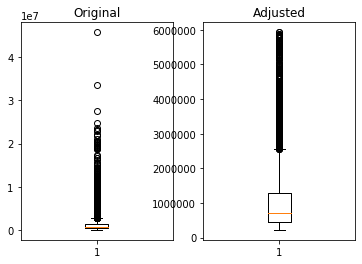

In [3]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

pd_series = data['price_T']
pd_series_adjusted = pd_series[pd_series.between(pd_series.quantile(.05), pd_series.quantile(.95))] 

ax1.boxplot(pd_series)
ax1.set_title('Original')

ax2.boxplot(pd_series_adjusted)
ax2.set_title('Adjusted')

plt.show()

In [4]:
sns.set(rc={'figure.figsize':(10,6)})


 mu = 1528756.94 and sigma = 2602758.26



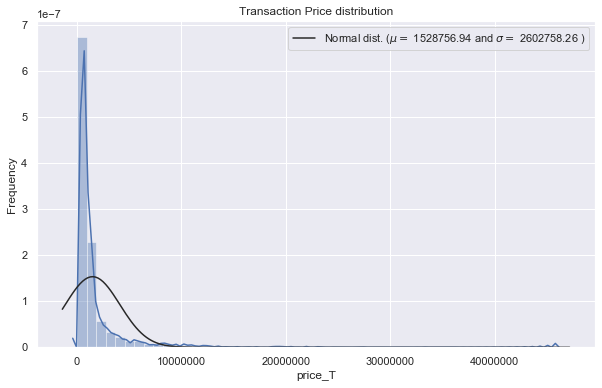

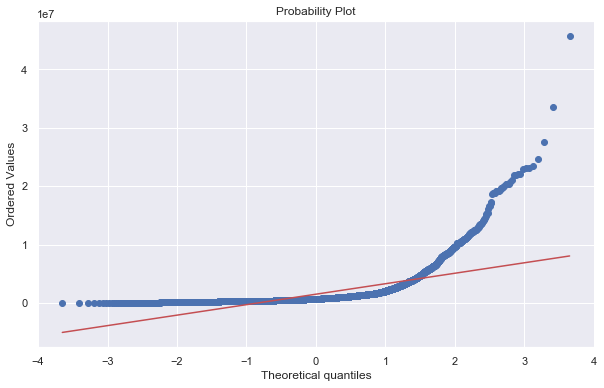

In [5]:
sns.distplot(data['price_T'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['price_T'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Transaction Price distribution')
plt.ticklabel_format(style='plain', axis='x')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['price_T'], plot=plt)

plt.ticklabel_format(style='plain', axis='x')
plt.show()

# drop outlier

In [6]:
data.shape

(5297, 47)

In [8]:
#data.sort_values('price_T',ascending=False).head()

In [9]:
len(data)*(0.05)

264.85

In [10]:
data = data.sort_values('price_T',ascending=False).iloc[265:]

In [11]:
data.shape

(5032, 47)

In [12]:
data['price_T'].describe()

count    5.032000e+03
mean     1.042847e+06
std      1.025252e+06
min      4.046412e+04
25%      4.094167e+05
50%      6.790387e+05
75%      1.244102e+06
max      5.926887e+06
Name: price_T, dtype: float64

# split dataset

In [18]:
data2=data.drop(['Accepted Year', 'NYXRCSA'], axis=1)

In [19]:
data2['Doorman']=data2['Doorman'].fillna(0)
data2['Pets']=data2['Pets'].fillna(0)

In [20]:
data2=data2.drop(['storage', 'common commercial ','administration'], axis=1)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data2.drop(['Closing Price','price_T','price_T/sq_ft', 'Price_ft2',
                                                               'type','Neighborhood',], axis=1),
                                                   data2['price_T'],
                                                   test_size=0.2,
                                                   random_state=42)
X_train.shape, X_test.shape

((4025, 36), (1007, 36))

In [22]:
from sklearn.pipeline import Pipeline
from feature_engine import categorical_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from feature_engine import missing_data_imputers as mdi

In [23]:
miss_col=['common interest','Offering Price','monthli tax','monthli charg common','monthly carrying charges',
'common residential units','payroll','gas/ hot water/heat','electricity','water sewer','services supplies',
'insurance','management','legal and audit','contingency','beds2','baths2']

In [24]:
data_pipeline = Pipeline([
    #imput missing data
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                          variables=miss_col)),
    # feature Scaling
    ('scale', MinMaxScaler()) 
])

In [25]:
data_pipeline.fit(X_train,y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(variables=['common interest',
                                              'Offering Price', 'monthli tax',
                                              'monthli charg common',
                                              'monthly carrying charges',
                                              'common residential units',
                                              'payroll', 'gas/ hot water/heat',
                                              'electricity', 'water sewer',
                                              'services supplies', 'insurance',
                                              'management', 'legal and audit',
                                              'contingency', 'beds2',
                                              'baths2'])),
                ('scale', MinMaxScaler())])

In [26]:
X_train=data_pipeline.transform(X_train)
X_test=data_pipeline.transform(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Keras

In [28]:
X_train.shape

(4025, 36)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [30]:
model = Sequential()

model.add(Dense(36,activation='relu'))
model.add(Dense(36,activation='relu'))
model.add(Dense(36,activation='relu'))
model.add(Dense(36,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [34]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400,
         callbacks=[early_stop],verbose=0)

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1332      
_________________________________________________________________
dense_1 (Dense)              multiple                  1332      
_________________________________________________________________
dense_2 (Dense)              multiple                  1332      
_________________________________________________________________
dense_3 (Dense)              multiple                  1332      
_________________________________________________________________
dense_4 (Dense)              multiple                  37        
Total params: 5,365
Trainable params: 5,365
Non-trainable params: 0
_________________________________________________________________


In [36]:
losses = pd.DataFrame(model.history.history)

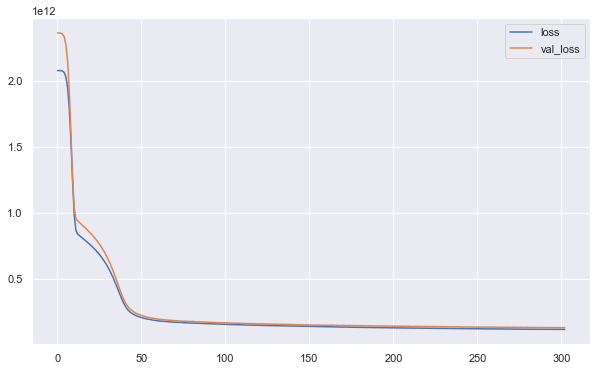

In [37]:
losses.plot()

In [38]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [39]:
predictions = model.predict(X_test)

In [40]:
np.sqrt(mean_squared_error(y_test,predictions))

361424.08611059794

In [41]:
explained_variance_score(y_test,predictions)

0.8878654259212384

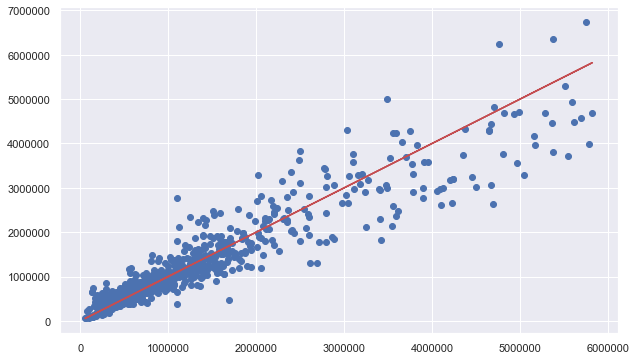

In [42]:
# Our predictions
plt.scatter(y_test,predictions)

# Perfect predictions
plt.plot(y_test,y_test,'r')

In [44]:
errors = y_test.values.reshape(1007, 1) - predictions

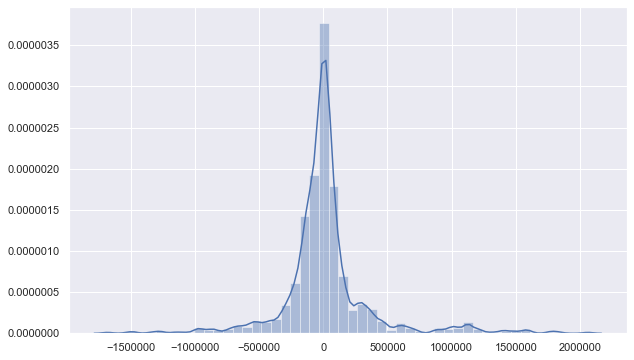

In [45]:
sns.distplot(errors)